L2-regularized logistic regression for binary or multiclass classification; trains a model (on `train.txt`), optimizes L2 regularization strength on `dev.txt`, and evaluates performance on `test.txt`.  Reports test accuracy with 95% confidence intervals and prints out the strongest coefficients for each class.

In [46]:
from scipy import sparse
from sklearn import linear_model
from collections import Counter
import numpy as np
import operator
import nltk
import math
from scipy.stats import norm
from sklearn.feature_extraction.text import TfidfVectorizer

In [47]:

!python -m nltk.downloader punkt

/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [48]:
def load_data(filename):
    X = []
    Y = []
    with open(filename, encoding="utf-8") as file:
        for line in file:
            cols = line.split("\t")
            idd = cols[0]
            label = cols[2].lstrip().rstrip()
            text = cols[3]

            X.append(text)
            Y.append(label)

    return X, Y


In [62]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd

class Classifier:

    def __init__(self, feature_method, trainX, trainY, devX, devY, testX, testY):
        self.feature_vocab = {}
        self.feature_method = feature_method
        self.min_feature_count=2
        self.log_reg = None

        self.trainY=trainY
        self.devY=devY
        self.testY=testY
        
        self.trainX = self.process(trainX, training=True)
        self.devX = self.process(devX, training=False)
        self.testX = self.process(testX, training=False)

    # Featurize entire dataset
    def featurize(self, data):
        featurized_data = []
        for text in data:
            feats = self.feature_method(text)
            featurized_data.append(feats)
        return featurized_data

    # Read dataset and returned featurized representation as sparse matrix + label array
    def process(self, X_data, training = False):
        
        data = self.featurize(X_data)

        if training:
            fid = 0
            feature_doc_count = Counter()
            for feats in data:
                for feat in feats:
                    feature_doc_count[feat]+= 1

            for feat in feature_doc_count:
                if feature_doc_count[feat] >= self.min_feature_count:
                    self.feature_vocab[feat] = fid
                    fid += 1

        F = len(self.feature_vocab)
        D = len(data)
        X = sparse.dok_matrix((D, F))
        for idx, feats in enumerate(data):
            for feat in feats:
                if feat in self.feature_vocab:
                    X[idx, self.feature_vocab[feat]] = feats[feat]

        return X


    # Train model and evaluate on held-out data
    def train(self):
        (D,F) = self.trainX.shape
        best_dev_accuracy=0
        best_model=None
        for C in [0.1, 1, 10, 100]:
            self.log_reg = linear_model.LogisticRegression(C = C, max_iter=1000)
            self.log_reg.fit(self.trainX, self.trainY)
            training_accuracy = self.log_reg.score(self.trainX, self.trainY)
            development_accuracy = self.log_reg.score(self.devX, self.devY)
            if development_accuracy > best_dev_accuracy:
                best_dev_accuracy=development_accuracy
                best_model=self.log_reg

#             print("C: %s, Train accuracy: %.3f, Dev accuracy: %.3f" % (C, training_accuracy, development_accuracy))

        self.log_reg=best_model
        

    def test(self):
        return self.log_reg.score(self.testX, self.testY)
    
    def cMatrix(self):
      "self, feature_method, trainX, trainY, devX, devY, testX, testY"
      pY = self.log_reg.predict(self.testX)
      cm = confusion_matrix(self.testY, pY)
      cm_df = pd.DataFrame(cm,
                           index = ['Not Popular', 'Average', 'Popular'],
                           columns = ['Not Popular', 'Average', 'Popular'])
      plt.figure(figsize=(5,4))
      sns.heatmap(cm_df, annot=True)
      plt.title('Confusion Matrix')
      plt.ylabel('Actal Values')
      plt.xlabel('Predicted Values')
      plt.show()

    def printWeights(self, n=10):

        reverse_vocab=[None]*len(self.log_reg.coef_[0])
        for k in self.feature_vocab:
            reverse_vocab[self.feature_vocab[k]]=k

        # binary
        if len(self.log_reg.classes_) == 2:
              weights=self.log_reg.coef_[0]

              cat=self.log_reg.classes_[1]
              for feature, weight in list(reversed(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1))))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

              cat=self.log_reg.classes_[0]
              for feature, weight in list(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1)))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

        # multiclass
        else:
          for i, cat in enumerate(self.log_reg.classes_):

              weights=self.log_reg.coef_[i]

              for feature, weight in list(reversed(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1))))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

            

In [72]:
import nltk
nltk.download('opinion_lexicon')

from nltk.corpus import opinion_lexicon


def binary_bow_featurize(text):
    feats = {}
    words = nltk.word_tokenize(text)

    #To assess capitalization of text (whether title contains at least one word that's in ALLCAP)
    ALLCAP = 0
    exclam = 0
    qmark = 0
    sarc_1 = 0
    sarc = set(['...', '??? ', ':)', ':(', 'lmao'])

    # Get the positive and negative words from the opinion lexicon
    positive_words = set(opinion_lexicon.positive())
    negative_words = set(opinion_lexicon.negative())

    # Add some custom negative words
    negative_words.update(set(['not', 'no', 'never', 'hate', 'sad', 'Not worth', 'not good']))
    negative = 0
    # Add some custom positive words
    positive_words.update(set(['awesome', 'fantastic', 'amazing', 'love', 'happy', 'fun', 'the best', 'finally made it']))
    positive = 0

    for word in words:
        if len(word) != 1 and word == word.upper():
          ALLCAP = 1

        word=word.lower()
        if word in negative_words:
          negative += 1
        if word in positive_words:
          positive += 1

        if word in sarc:
          sarc_1 = 1
        if word == '?':
          qmark = 1
        if word == '!':
          exclam = 1

    length = len(words)

    #Clarity
    if length <= 10 or qmark == 1:
      feats['Clarity'] = 1

    #Sarcasm
    if exclam == 1 or sarc_1 == 1 or ALLCAP == 1:
      feats['Sarcasm'] = 1

    #Tone
    if positive > negative:
      feats['positive'] = 1
    elif negative > positive:
      feats['negative'] = 1
    else:
      feats['neutral'] = 1

    #Q vs. Statement
    if qmark == 1:
      feats['QS'] = 1

    #Capitalization
    if ALLCAP == 1:
      feats['allcap'] = 1


    #Sentence Length
    if length <= 10:
        feats['length:0-10'] = 1
    elif length <= 20:
        feats['length:11-20'] = 1
    else:
        feats['length:20+'] = 1
            
    return feats



[nltk_data] Downloading package opinion_lexicon to /root/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!


In [73]:
def confidence_intervals(accuracy, n, significance_level):
    critical_value=(1-significance_level)/2
    z_alpha=-1*norm.ppf(critical_value)
    se=math.sqrt((accuracy*(1-accuracy))/n)
    return accuracy-(se*z_alpha), accuracy+(se*z_alpha)

In [74]:
def run(trainingFile, devFile, testFile):
    trainX, trainY=load_data(trainingFile)
    devX, devY=load_data(devFile)
    testX, testY=load_data(testFile)
    
    simple_classifier = Classifier(binary_bow_featurize, trainX, trainY, devX, devY, testX, testY)
    simple_classifier.train()
    accuracy=simple_classifier.test()
    
    lower, upper=confidence_intervals(accuracy, len(testY), .95)
    print("Test accuracy for best dev model: %.3f, 95%% CIs: [%.3f %.3f]\n" % (accuracy, lower, upper))

    simple_classifier.printWeights()
    simple_classifier.cMatrix()
    


Test accuracy for best dev model: 0.545, 95% CIs: [0.447 0.642]

Average	0.162	QS
Average	0.152	length:20+
Average	0.127	Clarity
Average	0.124	neutral
Average	0.113	allcap
Average	-0.030	Sarcasm
Average	-0.033	length:11-20
Average	-0.034	positive
Average	-0.089	negative
Average	-0.119	length:0-10

Not popular	0.210	negative
Not popular	0.142	length:11-20
Not popular	0.054	Sarcasm
Not popular	0.053	length:0-10
Not popular	0.005	allcap
Not popular	-0.001	Clarity
Not popular	-0.013	QS
Not popular	-0.052	positive
Not popular	-0.158	neutral
Not popular	-0.195	length:20+

Popular	0.104	positive
Popular	0.048	length:20+
Popular	0.024	length:0-10
Popular	0.009	Sarcasm
Popular	-0.003	neutral
Popular	-0.071	length:11-20
Popular	-0.087	allcap
Popular	-0.101	negative
Popular	-0.116	QS
Popular	-0.150	Clarity

label	0.042	length:0-10
label	0.038	neutral
label	0.024	Clarity
label	-0.005	length:20+
label	-0.018	positive
label	-0.020	negative
label	-0.031	allcap
label	-0.033	QS
label	-0.033	Sarcasm
lab

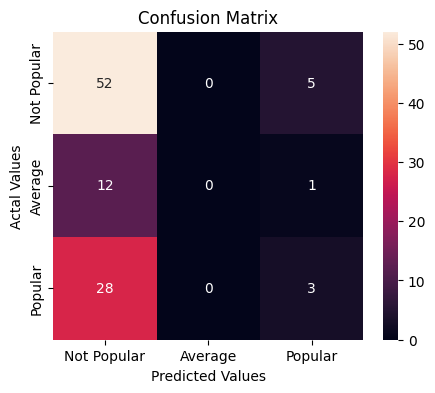

In [75]:
trainingFile = "train.txt"
devFile = "dev.txt"
testFile = "test.txt"
    
run(trainingFile, devFile, testFile)
